<a href="https://colab.research.google.com/github/BMugo84/pytorch_in_25_hours/blob/main/06_pytorch_test_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recreate model_2 used in this notebook (the same model from the CNN Explainer website, also known as TinyVGG) capable of fitting on the MNIST dataset. It will incorporate transfer learning knowledge

In [ ]:
# import necessary libraries
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine


[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 12.95 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [ ]:
# setup device agnostic code. you may start off with cpu so as to not waste your gpu credits
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data

In [ ]:
# import neceessary libraries
import os
from pathlib import Path

# setup path to data folder
data_path = Path("data/")

# check if path exists
if not data_path.exists():
    # steup train data
    train_data = datasets.Imagenette(
        root="data",
        split="train",
        size="320px",
        download=True,
        transform=None,
        target_transform=None # for now we wont use transforms
    )
    test_data = datasets.Imagenette(
        root="data",
        split="val", # val means validation/test data
        size="320px",
        download=False,
        transform=None,
        target_transform=None # for now we wont use transforms
    )

len(train_data), len(test_data)


100%|██████████| 341663724/341663724 [00:23<00:00, 14365171.06it/s]


Extracting data/imagenette2-320.tgz to data


(9469, 3925)

In [ ]:
class_names_test = train_data.classes
class_names_test

[('tench', 'Tinca tinca'),
 ('English springer', 'English springer spaniel'),
 ('cassette player',),
 ('chain saw', 'chainsaw'),
 ('church', 'church building'),
 ('French horn', 'horn'),
 ('garbage truck', 'dustcart'),
 ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
 ('golf ball',),
 ('parachute', 'chute')]

In [ ]:
class_to_idx_test = train_data.class_to_idx
class_to_idx_test

{'tench': 0,
 'Tinca tinca': 0,
 'English springer': 1,
 'English springer spaniel': 1,
 'cassette player': 2,
 'chain saw': 3,
 'chainsaw': 3,
 'church': 4,
 'church building': 4,
 'French horn': 5,
 'horn': 5,
 'garbage truck': 6,
 'dustcart': 6,
 'gas pump': 7,
 'gasoline pump': 7,
 'petrol pump': 7,
 'island dispenser': 7,
 'golf ball': 8,
 'parachute': 9,
 'chute': 9}

In [ ]:
train_dir = data_path / "imagenette2-320" / "train"
test_dir = data_path / "imagenette2-320" / "val"
train_dir.exists()

True

since class names are mismatched with folder names, we will have to rename the folders.

from my pov:

```

[
    'n01440764': ('tench', 'Tinca tinca'),
    'n02102040': ('English springer', 'English springer spaniel'),
    'n02979186': ('cassette player',),
    'n03000684': ('chain saw', 'chainsaw'),
    'n03028079': ('church', 'church building'),
    'n03394916': ('French horn', 'horn'),
    'n03417042': ('garbage truck', 'dustcart'),
    'n03425413': ('gas pump', 'gasoline pump', 'petrol pump', 'island dispenser'),
    'n03445777': ('golf ball',),
    'n03888257': ('parachute', 'chute')
]
```


In [ ]:
# testing folder name change with train_dir
from pathlib import Path

name_mapping = {
    'n01440764': 'tench',
    'n02102040': 'English_springer',
    'n02979186': 'cassette_player',
    'n03000684': 'chain_saw',
    'n03028079': 'church',
    'n03394916': 'French_horn',
    'n03417042': 'garbage_truck',
    'n03425413': 'gas_pump',
    'n03445777': 'golf_ball',
    'n03888257': 'parachute'
}
# base_path = train_dir
base_path =  test_dir

for old_name, new_name in name_mapping.items():
    old_folder = base_path / old_name
    new_folder = base_path / new_name
    if old_folder.exists():
        old_folder.rename(new_folder)
        print(f"Renamed {old_folder} to {new_folder}")
    else:
        print(f"Folder {old_folder} does not exist")



Renamed data/imagenette2-320/val/n01440764 to data/imagenette2-320/val/tench
Renamed data/imagenette2-320/val/n02102040 to data/imagenette2-320/val/English_springer
Renamed data/imagenette2-320/val/n02979186 to data/imagenette2-320/val/cassette_player
Renamed data/imagenette2-320/val/n03000684 to data/imagenette2-320/val/chain_saw
Renamed data/imagenette2-320/val/n03028079 to data/imagenette2-320/val/church
Renamed data/imagenette2-320/val/n03394916 to data/imagenette2-320/val/French_horn
Renamed data/imagenette2-320/val/n03417042 to data/imagenette2-320/val/garbage_truck
Renamed data/imagenette2-320/val/n03425413 to data/imagenette2-320/val/gas_pump
Renamed data/imagenette2-320/val/n03445777 to data/imagenette2-320/val/golf_ball
Renamed data/imagenette2-320/val/n03888257 to data/imagenette2-320/val/parachute


# 2. create datasets and dataloaders

We can try efficientnet_b1 as a minor change of pace

In [ ]:
# fetching weights of efficientnet_b1
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
weights

EfficientNet_B1_Weights.IMAGENET1K_V2

In [ ]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[240]
    resize_size=[255]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# create training and testing dataloaders and fetch class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a6a91a96440>,
 ['n01440764',
  'n02102040',
  'n02979186',
  'n03000684',
  'n03028079',
  'n03394916',
  'n03417042',
  'n03425413',
  'n03445777',
  'n03888257'])

# 3. Getting a pretrained model

what we know:

our dataset has 10 class_names

In [ ]:
len(class_names)

10

In [ ]:
model = torchvision.models.efficientnet_b1(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 164MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# summarize model
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [ ]:
# freeze the feauture layers
# NB sometimes it is feauture , other times it is feature British english innit?!
# model.features
for params in model.features.parameters():
    params.requires_grad = False


# summarize model
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [ ]:
# change the classifier layer to match our classes
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=len(class_names), # same number of output units as our number of classes
                    bias=True)
).to(device)

# summarize model
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4.  Train the model

In [ ]:
# define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01)


In [ ]:
# train the model
torch.manual_seed(42) # we use seeding so as to get the same random results
torch.cuda.manual_seed(42) #  everytime. its like selecting randoms from earth in the midsts of an infinite universe

# start the timer
from timeit import default_timer as timer
start_time = timer()

# setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0316 | train_acc: 0.9906 | test_loss: 10.0574 | test_acc: 0.2901
Epoch: 2 | train_loss: 0.0255 | train_acc: 0.9923 | test_loss: 11.1859 | test_acc: 0.2917
Epoch: 3 | train_loss: 0.0211 | train_acc: 0.9940 | test_loss: 12.3791 | test_acc: 0.2909
Epoch: 4 | train_loss: 0.0190 | train_acc: 0.9936 | test_loss: 13.8470 | test_acc: 0.2907
Epoch: 5 | train_loss: 0.0256 | train_acc: 0.9925 | test_loss: 14.4450 | test_acc: 0.2909
[INFO] Total training time: 357.269 seconds


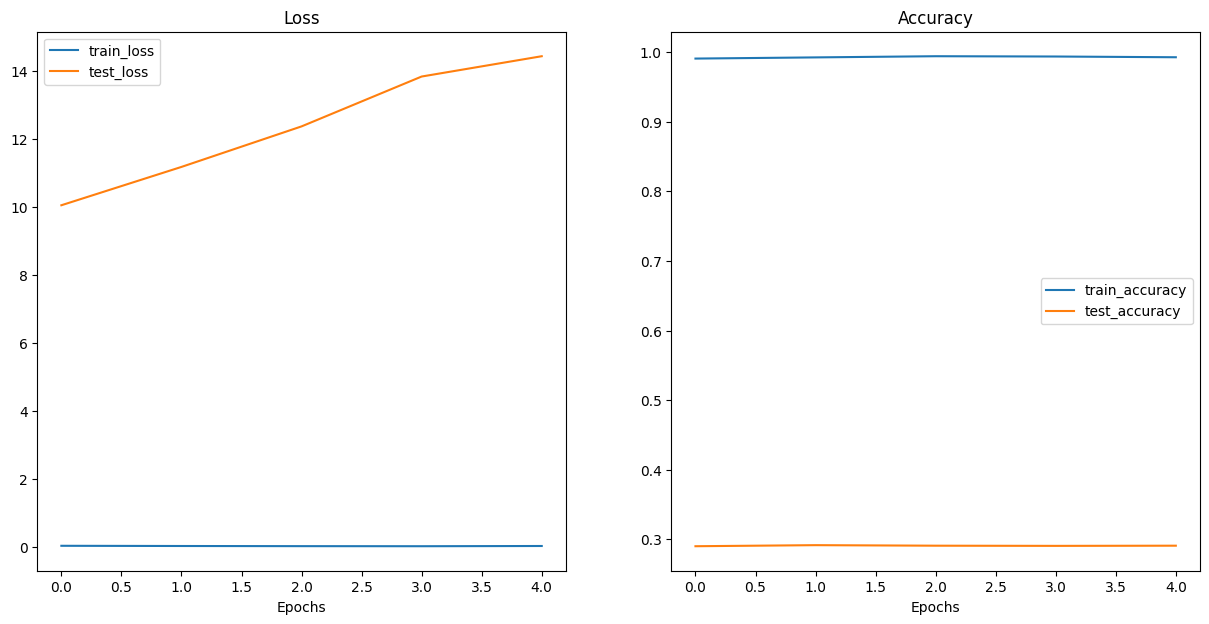

In [ ]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)